# Gruppe J

<table>
  <tbody>
    <tr>
      <th>Nachname</th>
      <th>Vorname</th>
      <th>Matrikelnr.</th>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Dietrich</td>
      <td>Maximilian</td>
      <td>395320</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Harisha</td>
      <td>Adithya Sakrepatna</td>
      <td>455906</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Konrad</td>
      <td>Jimmy</td>
      <td>463221</td>
    </tr>
  </tbody>
  <tbody>
    <tr>
      <td>Lian</td>
      <td>David</td>
      <td>451051</td>
    </tr>
  </tbody>
</table>



## Modulimport

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (AutoMinorLocator, FormatStrFormatter)
import numpy as np
import copy as copy
import statsmodels.api as sm
from itertools import cycle
from multiprocessing import cpu_count

from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold

from sklearn.linear_model import Lasso
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR

AttributeError: module 'numpy' has no attribute 'MachAr'

### Datenimport

In [4]:
df_raw = pd.read_excel('Aufgabe_1_Gloss_Optimization.xlsx')
pd.set_option('display.expand_frame_repr', False)               # keine Daten beim Print ausblenden
print('Dimensionen des Datensatzes "Gloss_Optimization": %d, %d\n' % df_raw.shape)
print(df_raw.tail())

Dimensionen des Datensatzes "Gloss_Optimization": 58, 15

    V13    V15  V16    V18  V19    V21       V28       V29       V30       V31       V32       V33       V34  V39  gloss
53  0.2  HMW 1  0.2  HMW 6  0.0    NaN  0.217525  0.195159  0.005929  0.018465 -0.006291  0.002313  0.017525    5   4800
54  0.4  HMW 5  0.0    NaN  0.0    NaN  0.394731 -0.022175 -0.013080 -0.003039 -0.035266 -0.009641 -0.005269    5   6000
55  0.4  HMW 6  0.0    NaN  0.0    NaN  0.414315 -0.006811 -0.007612  0.012732 -0.000735 -0.001841  0.014315    5   4700
56  0.2  HMW 5  0.2  LMW 6  0.0    NaN  0.207545 -0.002715 -0.000442 -0.006795  0.000325  0.203296  0.007545    6   8000
57  0.2  HMW 1  0.1  LMW 6  0.1  LMW 1  0.011453  0.204203 -0.005749 -0.000304  0.090017  0.117056  0.011453    8   7300


### Darstellung der importierten Daten

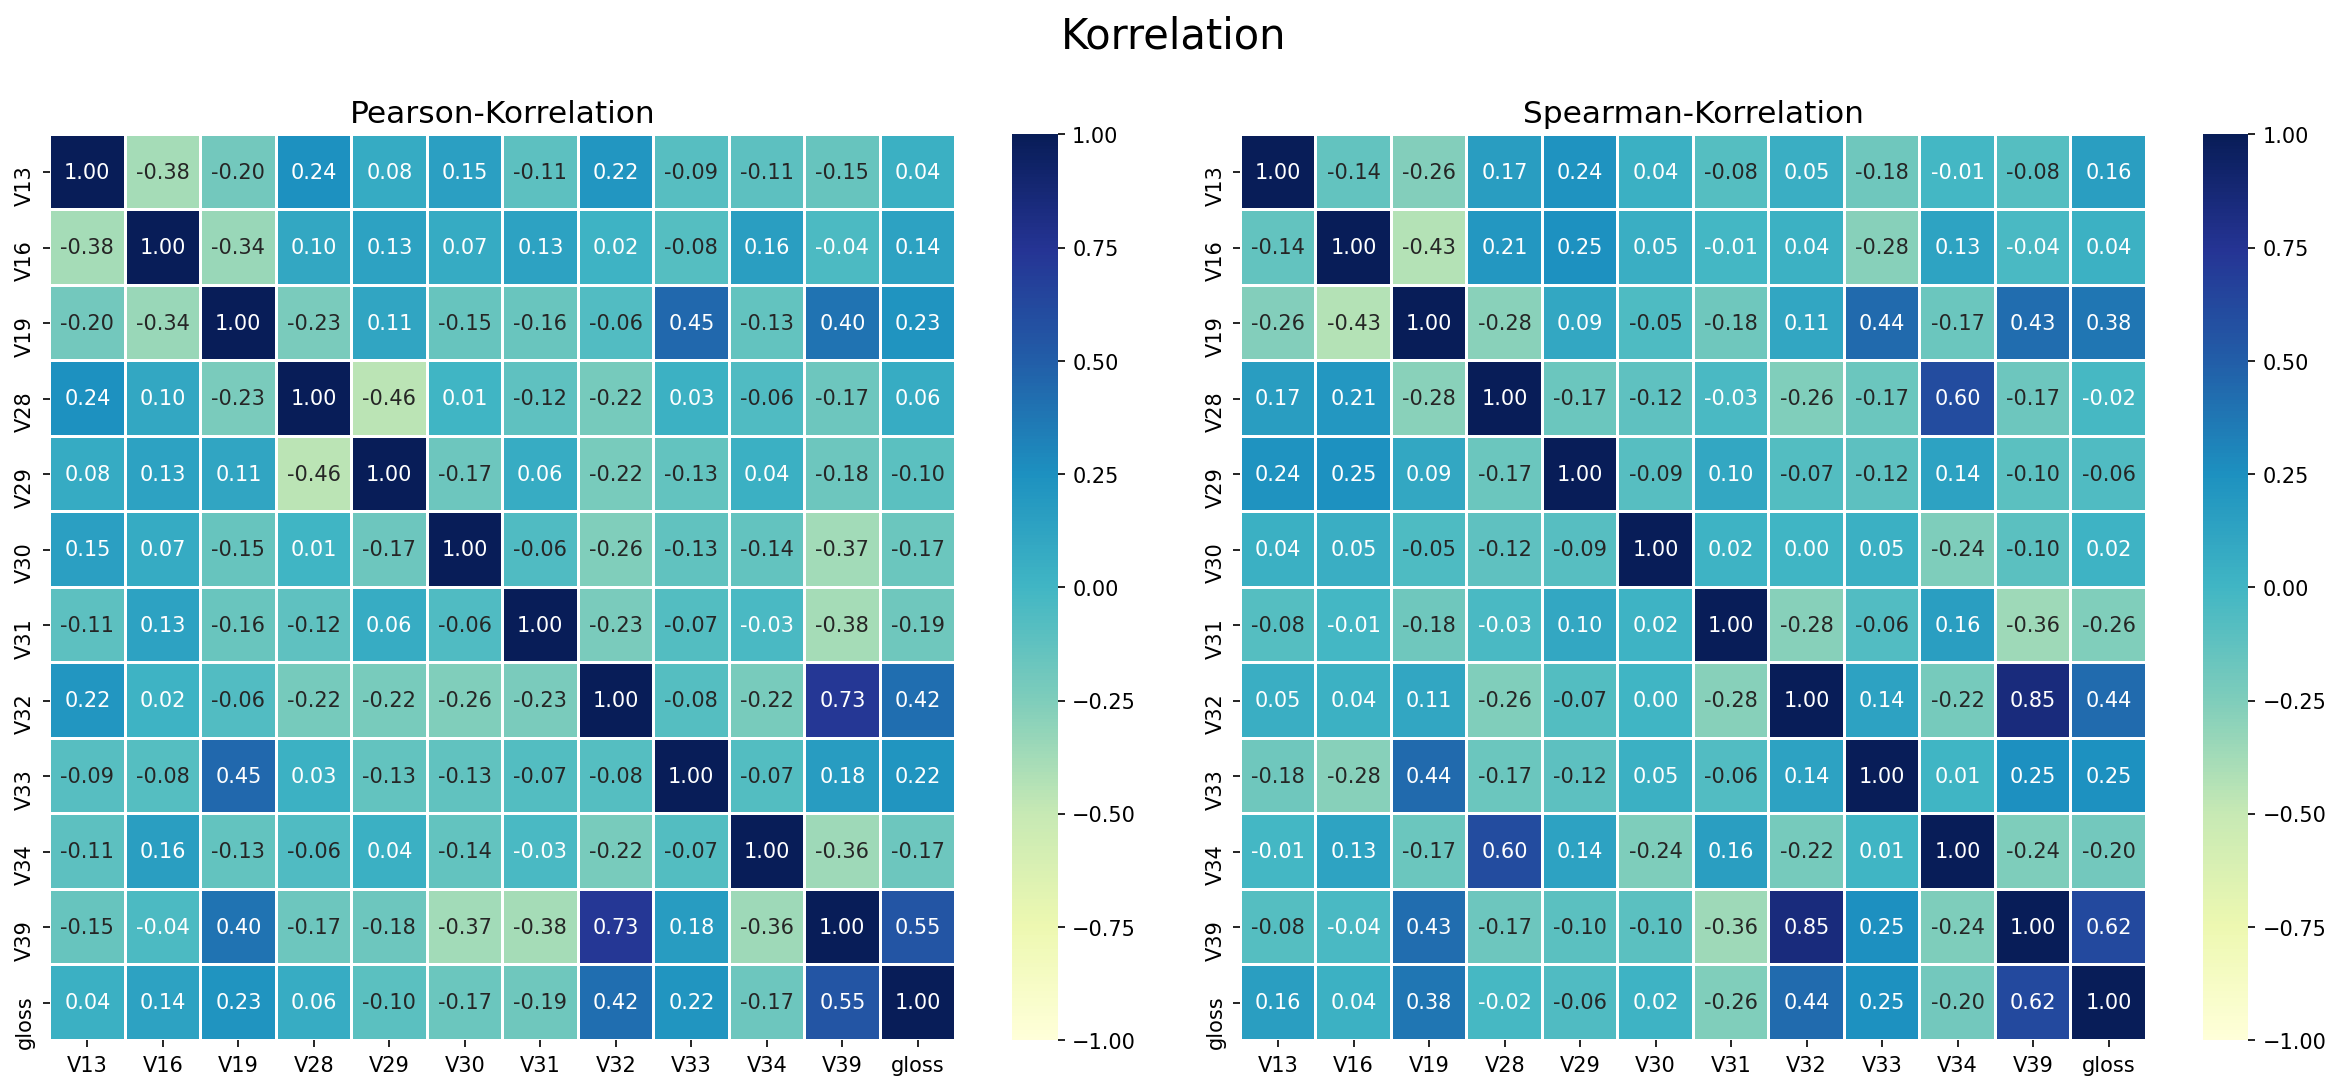

In [5]:
# Korrelationsmatrix berechnen und darstellen
r_pearson   = df_raw.corr(method='pearson')
r_spearman  = df_raw.corr(method='spearman')

fig1, ax = plt.subplots(1, 2, figsize=(20,8), dpi = 150)
fig1.subplots_adjust(wspace=0.05, hspace=0.25)
fig1.suptitle('Korrelation', fontsize=20)

sns.heatmap(r_pearson, ax=ax[0], linewidth = 1 , annot = True, cmap="YlGnBu", vmin=-1, vmax=1, square=True, fmt="0.2f");
ax[0].set_title("Pearson-Korrelation", fontsize=15);

sns.heatmap(r_spearman, ax=ax[1], linewidth = 1 , annot = True, cmap="YlGnBu", vmin=-1, vmax=1, square=True, fmt="0.2f");
ax[1].set_title("Spearman-Korrelation", fontsize=15);

Zu sehen ist, dass viele Features aufgrund der niedrigen Korrelation zur Zielgröße "gloss" keine hohe relevanz besitzen (bspw. V28).
Nur wenige Features, wie bspw. V32 und V39, besitzen eine hohe Korrelation. Die Korrelationen von Pearson und Spearman sind sich betragsmäßig ähnlich.
Das Feature V19 weist jedoch einen deutlich höheren Korrelationskoeffienten bei Spearman auf. Das deutet darauf hin, dass der Zusammenhang zwischen V19 und gloss eher nichtlinear ist.
Allgemein weisen die Features untereinander nur eine geringe oder keine Korrelation auf. Eine Ausnahme stellt die Korrelation zwischen V32 und V39 mit 0.73 (Pearson) bzw. 0.85 (Spearman) dar.  
Berücksichtigt wurden nur nicht kategorische Features.

### Daten Vorverarbeitung

Hot-One-Encoder, Datenplitt, Z-Transformation

In [6]:
rnd_state = 1

# Testdaten: letzten 10 %
n_test = 0.1

# Zielgröße
y = df_raw.iloc[:,-1]

# Features
X_raw       = df_raw.iloc[:,0:-1]

# Hot-One-Encoder fuer Strings bzw. alle Objekte
string_col_indices = np.where(X_raw.dtypes == object)
string_col_indices = string_col_indices[0]

ct          = ColumnTransformer(transformers=[('encoder', OneHotEncoder(drop='first'), string_col_indices)], remainder='passthrough')
X_HOE       = ct.fit_transform(X_raw)

# Header
X_header        = ct.get_feature_names_out()
y_header        = df_raw.columns[-1]
n_row, n_col    = X_HOE.shape

print('y Header: \n%s\n' % y_header)
print('X Header (%d): \n%s\n' % (n_col, np.array(X_header)))

X_TrVal, X_T, y_TrVal, y_T = train_test_split(X_HOE, y, test_size=n_test, random_state=rnd_state, shuffle=True)

# z-Transformation
# Test-Daten mit Mittelwert und Standardabweichung von Trainings-/Validierungsdaten transformieren
sc         = StandardScaler()
X_TrVal_z  = sc.fit_transform(X_TrVal)
X_T_z      = sc.transform(X_T)

# Ausreißer entfernen
# Zielwerte oberhalb von 11.000 koennen schwer vorhergesagt werden
nrm             = y_TrVal < 11000
X_TrVal_z_woo   = X_TrVal_z[nrm.values,:]
X_TrVal_woo     = X_TrVal[nrm.values,:]
y_TrVal_woo     = y_TrVal[nrm.values]
X_o_z           = X_TrVal_z[~nrm.values,:]
X_TrVal_o       = X_TrVal[~nrm.values,:]
y_TrVal_o       = y_TrVal[~nrm.values]

NameError: name 'ColumnTransformer' is not defined

In [7]:
def fcnl_error(results, X_Tr, X_T, X_o, y_Tr, y_T):
    # Berechnung der Modellwerte und der Fehler

    if len(X_o) != 0:
        yM_o = results.predict(X_o)
    else:
        yM_o = 0

    # Modellwerte berechnen
    yM_Tr       = results.predict(X_Tr)
    yM_T        = results.predict(X_T)
    e_Tr        = y_Tr - yM_Tr
    e_T         = y_T - yM_T

    # Kenngrößen berechnen
    rmse_Tr     = metrics.mean_squared_error(y_Tr, yM_Tr, squared=False)
    rmse_T      = metrics.mean_squared_error(y_T, yM_T, squared=False)
    R2_Tr       = metrics.r2_score(y_Tr, yM_Tr)
    R2_T        = metrics.r2_score(y_T, yM_T)
    nrmse_Tr    = 1 - np.sqrt(abs(R2_Tr - 1))
    nrmse_T     = 1 - np.sqrt(abs(R2_T - 1))

    # Dict anlegen
    rmse        = {'TrVal': rmse_Tr,   'T': rmse_T}
    R2          = {'TrVal': R2_Tr,     'T': R2_T}
    nrmse       = {'TrVal': nrmse_Tr,  'T': nrmse_T}

    err = {'RMSE': rmse, 'NRMSE': nrmse, 'R2': R2}

    return results, yM_Tr, yM_T, yM_o, e_Tr, e_T, err


def fcnl_plot(titel, y_TrVal, y_T, y_o, yM_TrVal, yM_T, yM_o, e_TrVal, e_T):
    # Plotten der Ergebnisse

    # Min und Max Werte brechnen
    if len(y_o) == 0 and len(yM_o) == 0:
        y_o = np.nan
        yM_o = np.nan
        ymin = np.floor(np.min([y.min(), yM_TrVal.min(), yM_T.min()])/1000)*1000
        ymax = np.ceil(np.max([y.max(), yM_TrVal.max(), yM_T.max()])/1000)*1000
    else:
        ymin = np.floor(np.min([y.min(), yM_TrVal.min(), yM_T.min(), np.min(yM_o)])/1000)*1000
        ymax = np.ceil(np.max([y.max(), yM_TrVal.max(), yM_T.max(), np.max(yM_o)])/1000)*1000

    # Plott erzeugen
    fig, ax = plt.subplots(1, 3, figsize=(10,2), dpi = 150)
    fig.subplots_adjust(wspace=0.5, hspace=0.2)

    # Modell über Zielgröße plotten
    fig.suptitle(titel)
    ax[0].plot([ymin, ymax], [ymin, ymax], 'k-', lw = 0.75)
    ax[0].plot(y_TrVal, yM_TrVal, '.', alpha = 0.5, label = 'Train+Val')
    ax[0].plot(y_T, yM_T, '.', alpha = 0.5, label = 'Test')
    if np.size(y_o) > 1 or ~np.isnan(y_o):
        ax[0].plot(y_o, yM_o, '.', alpha = 0.5, label = 'entfernte Ausreißer', color='k')

    ax[0].set_ylabel('Modell')
    ax[0].set_xlabel('Messung')
    ax[0].set_ylim([ymin, ymax])
    ax[0].set_xlim([ymin, ymax])
    ax[0].legend(loc="upper left", fontsize=6);

    # Fehlerhistogramm
    _, bins, _ = ax[1].hist(e_TrVal, density = True, bins = 'auto', label = 'Train+Val')
    ax[1].hist(e_T, density = True, label = 'Test', alpha = 0.5) # , bins=bins
    ax[1].set_ylabel('rel. Haeufigkeit')
    ax[1].set_xlabel('Residuum')
    ax[1].legend(loc = "upper left", fontsize=6);

    # Fehler über Index
    ax[2].plot(y_TrVal.index, e_TrVal, '.', label = 'Train+Val')
    ax[2].plot(y_T.index, e_T, '.', label = 'Test')
    ax[2].set_ylabel('y-yM')
    ax[2].set_xlabel('Index')
    ax[2].legend(loc = "upper left", fontsize=6);

### OLS

Feature mit höchsten pvalues automatisch entfernen, bis alle pvalues unter 0.05 liegen.

In [8]:
def fcnl_ols_red(X_header, X_Tr, X_T, X_o, y_Tr, y_T):
    rem          = []    # zu entfernende Features
    b_repeat     = True

    # Header erzeugen, falls nicht übergeben
    if len(X_header) != 0:
        X_header_ols = X_header.copy()
    else:
        X_header_ols = [['x'+str(x)] for x in range(1, np.size(X_Tr,1) + 1)]

    # Variablen kopieren
    X_ols_Tr     = X_Tr.copy()
    X_ols_T      = X_T.copy()

    # Konstante hinzufügen
    X_Tr_wc      = sm.add_constant(X_ols_Tr, has_constant = 'add')  # Konstante hinzufügen
    X_T_wc       = sm.add_constant(X_ols_T, has_constant = 'add')   # Konstante hinzufügen (erzwungen)

    # Wenn Ausreißer übergeben, Feature kopieren und konstante hinzufügen
    if len(X_o) != 0:
        X_ols_o  = X_o.copy()
        X_o_wc   = sm.add_constant(X_ols_o, has_constant = 'add')   # Konstante hinzufügen (erzwungen)
    else:
        X_o_wc   = []

    # OLS erzeugen, fitten und automatisch Features mit höchsten Signifikanzniveau entfernen, bis alle Niveaus unter 0.05 liegen.
    while b_repeat:
        ols                 = sm.OLS(y_Tr, X_Tr_wc)                 # ols definieren
        ols.exog_names[1:]  = X_header_ols                          # headernames dem ols hinzufuegen
            
        ols                 = ols.fit()
        results_ols, yM_ols_Tr, yM_ols_T, yM_ols_o, e_ols_Tr, e_ols_T, ols_err = fcnl_error(ols, X_Tr_wc, X_T_wc, X_o_wc, y_Tr, y_T) # Kenngroeßen und Modellwerte berechnen

        p_ols       = results_ols.params                        # Parameter auslesen
        pvalue      = results_ols.summary2().tables[1]['P>|t|'] # pvalues auslesen

        if pvalue.max() <= 0.05:
            # Wenn alle p-values kleiner 0.05 sind -> Abbruch der Schleife
            b_repeat = False
        else:
            # Ansonsten, Feature mit hoechsten p-value entfernen
            rem          = np.where(pvalue.max() == pvalue)
            X_header_ols = np.delete(X_header_ols, rem[0]-1)
            X_Tr_wc      = np.delete(X_Tr_wc, rem, 1)
            X_T_wc       = np.delete(X_T_wc, rem, 1)
            if len(X_o) != 0:
                X_o_wc   = np.delete(X_o_wc, rem, 1)


    print(results_ols.summary())    # statistische Groeßen ausgeben
    n_ols = pvalue.shape[0]-1       # finale Anzahl Features

    return n_ols, X_Tr_wc, X_T_wc, X_o_wc, yM_ols_Tr, yM_ols_T, yM_ols_o, e_ols_Tr, e_ols_T, ols_err

def fcnl_print(modellart, n, err, comment):
    print('%15s:        %4d | %9.3f | %9.3f | %11.3f | %11.3f | %12.3f | %12.3f | %s' % (modellart, n, err['R2']['TrVal'], err['R2']['T'], err['RMSE']['TrVal'], err['RMSE']['T'], err['NRMSE']['TrVal'], err['NRMSE']['T'], comment)) 

In [9]:
print('Mit Ausreißer:')
n_ols_wo, X_TrVal_wc_wo, X_T_wc_wo,_ , yM_ols_TrVal_wo, yM_ols_T_wo, _, e_ols_TrVal_wo, e_ols_T_wo, ols_err_wo                              = fcnl_ols_red(X_header, X_TrVal_z, X_T_z, [], y_TrVal, y_T)
print('\n\nohne Ausreißer:')
n_ols_woo, X_TrVal_wc_woo, X_T_wc_woo, X_o_wc_woo, yM_ols_TrVal_woo, yM_ols_T_woo, yM_ols_o_woo, e_ols_TrVal_woo, e_ols_T_woo, ols_err_woo  = fcnl_ols_red(X_header, X_TrVal_z_woo, X_T_z, X_o_z, y_TrVal_woo, y_T)

fcnl_plot('OLS-Regression, (mit Ausreißer)'     , y_TrVal    , y_T,        [], yM_ols_TrVal_wo , yM_ols_T_wo ,           [], e_ols_TrVal_wo , e_ols_T_wo)
fcnl_plot('OLS-Regression, (ohne Ausreißer)'    , y_TrVal_woo, y_T, y_TrVal_o, yM_ols_TrVal_woo, yM_ols_T_woo, yM_ols_o_woo, e_ols_TrVal_woo, e_ols_T_woo)

print('\n\n                       Anz.P | R2 (Tr+V) | R2 (Test) | RMSE (Tr+V) | RMSE (Test) | NRMSE (Tr+V) | NRMSE (Test) | Kommentar')
fcnl_print('OLS'            , n_ols_wo      , ols_err_wo        , 'mit Ausreißer')
fcnl_print('OLS'            , n_ols_woo     , ols_err_woo       , 'ohne Ausreißer')

Mit Ausreißer:


NameError: name 'X_header' is not defined

Durch das automatische entfernen von Features mithilfe des Signifikanzniveaus der Paramter des OLS-Modells werden insgesamt 21 (mit Ausreißer) bzw. 23 (ohne Ausreißer) Features entfernt. 
Als Ausreißer werden gloss-Werte von mehr als 11000 defineirt, aufgrund diese sich mit unterscheidlichen Modellen nur schlecht vorhersagen lassen.
Die Trainingsergebnisse beider OLS-Modelle liefern bereits ein Bestimmtheitsmaß von über 0.9, wobei sie sich bei den Testergebnisse deutlich unterscheiden. Das Modell mit den Ausreißern zeigt eine schlechtere Verallgemeinerung, als Modell ohne Ausreißer.
Das Modell ohne Ausreißer liefert mit einem RMSE im Training- und im Testdatensatz von ca. 400 bereits gute Vorhersagen.

### Lasso

In [ ]:
def fcnl_lasso(X_l_TrVal, y_l_TrVal):
    a_min        = 0
    a_max        = np.log10(1000)
    alphas_lasso = np.logspace(a_min,a_max,int(np.ceil(a_max*100+1)))
    kf           = KFold(n_splits=5, shuffle=True, random_state=rnd_state)

    # Lasso mit unterschiedlichen alpha-Werten aufrufen

    coefs_lasso         = []    # Lasso-Koeffizienten MAtrix
    rmse_lkf_Tr_m       = []    # RMSE, Mittelwert der Trainingsdaten aus unterschiedlichen KFolds
    rmse_lkf_Tr_std     = []    # RMSE, Standardabweichung der Trainingsdaten aus unterschiedlichen KFolds
    rmse_lkf_V_m        = []    # RMSE, Mittelwert der Validierungsdaten
    rmse_lkf_V_std      = []    # RMSE, Standardabweichung der Validierungsdaten
    R2_lkf_Tr_m         = []    # R2, Mittelwert der Trainingsdaten
    R2_lkf_Tr_std       = []    # R2, Standardabweichung der Trainingsdaten
    R2_lkf_V_m          = []    # R2, Mittelwert der Validierungsdaten
    R2_lkf_V_std        = []    # R2, Standardabweichung der Validierungsdaten
    nrmse_lkf_Tr_m      = []    # normalized RMSE, Mittelwert der Trainingsdaten
    nrmse_lkf_Tr_std    = []    # normalized RMSE, Standardabweichung der Trainingsdaten
    nrmse_lkf_V_m       = []    # normalized RMSE, Mittelwert der Validierungsdaten
    nrmse_lkf_V_std     = []    # normalized RMSE, Standardabweichung der Validierungsdaten

    for i_a in range(len(alphas_lasso)):
        rmse_lkf_Tr   = []      # RMSE, Trainingsdaten der KFolds mit einem alpha
        rmse_lkf_V    = []      # RMSE, Validierungsdaten der KFolds mit einem alpha
        R2_lkf_Tr     = []      # R2, Trainingsdaten der KFolds mit einem alpha
        R2_lkf_V      = []      # R2, Validierungsdaten der KFolds mit einem alpha
        nrmse_lkf_Tr  = []      # NRMSE, Trainingsdaten der KFolds mit einem alpha
        nrmse_lkf_V   = []      # NRMSE, Validierungsdaten der KFolds mit einem alpha
        temp_coef     = []      # Koeffizienten der KFolds mit einem alpha

        for idx_Tr, idx_V in kf.split(X_l_TrVal):
            # Aufruf lasso mit aktuellem alpha, fuer jeden kfold
            # Datensaetze laden
            psi_Tr_z    = X_l_TrVal[idx_Tr,:]
            psi_V_z     = X_l_TrVal[idx_V,:]
            y_Tr        = y_l_TrVal.iloc[idx_Tr]
            y_V         = y_l_TrVal.iloc[idx_V]
            
            # Lasso-Modell aufrufen
            clf         = Lasso(alpha=alphas_lasso[i_a], max_iter=10000)
            clf.fit(psi_Tr_z, y_Tr)
            
            # Modellvorhersage
            yM_lkf_Tr   = clf.predict(psi_Tr_z)
            yM_lkf_V    = clf.predict(psi_V_z)
            
            # Koeffizienten speichern
            temp_coef.append(clf.coef_)

            # Kenngroeßen des KFolds berechnen und speichern
            rmse_lkf_Tr.append(metrics.mean_squared_error(y_Tr, yM_lkf_Tr, squared=False))
            rmse_lkf_V.append(metrics.mean_squared_error(y_V, yM_lkf_V, squared=False))
            R2_lkf_Tr.append(metrics.r2_score(y_Tr, yM_lkf_Tr))
            R2_lkf_V.append(metrics.r2_score(y_V, yM_lkf_V))
            nrmse_lkf_Tr.append(1 - np.sqrt(abs(R2_lkf_Tr[-1] - 1)))
            nrmse_lkf_V.append(1 - np.sqrt(abs(R2_lkf_V[-1] - 1)))

        # Mittelwert und Standardabweichung der Fehler berechnen und speichern
        rmse_lkf_Tr_m.append(np.mean(rmse_lkf_Tr))
        rmse_lkf_Tr_std.append(np.std(rmse_lkf_Tr,ddof=1))
        rmse_lkf_V_m.append(np.mean(rmse_lkf_V))
        rmse_lkf_V_std.append(np.std(rmse_lkf_V,ddof=1))
        R2_lkf_Tr_m.append(np.mean(R2_lkf_Tr))
        R2_lkf_Tr_std.append(np.std(R2_lkf_Tr,ddof=1))
        R2_lkf_V_m.append(np.mean(R2_lkf_V))
        R2_lkf_V_std.append(np.std(R2_lkf_V,ddof=1))
        nrmse_lkf_Tr_m.append(np.mean(nrmse_lkf_Tr))
        nrmse_lkf_Tr_std.append(np.std(nrmse_lkf_Tr,ddof=1))
        nrmse_lkf_V_m.append(np.mean(nrmse_lkf_V))
        nrmse_lkf_V_std.append(np.std(nrmse_lkf_V,ddof=1))
        coefs_lasso.append(np.mean(np.array(temp_coef),0))

    coefs_lasso = np.array(coefs_lasso)

    e_tol               = 5 # %, akzeptierter zusaetzlicher Fehler, um Anzahl Feature zu reduzieren

    opt_err_V_min       = np.min(rmse_lkf_V_m)   
    idx_opt_err_V_m     = np.where(rmse_lkf_V_m == opt_err_V_min)
    idx_opt_err_V_m     = idx_opt_err_V_m[0][-1]   # letzer gefundener Index

    # Index des Fehlers mit akzeptierter Fehlertoleranz bestimmen
    opt_err_V_m_diff = abs(rmse_lkf_V_m[idx_opt_err_V_m:] - opt_err_V_min*(1+e_tol/100))
    idx_err_V_tol    = np.where(opt_err_V_m_diff == np.min(opt_err_V_m_diff))
    idx_err_V_tol    = idx_err_V_tol[0][-1]     # letzer gefundener Index

    # opt. alpha und Anzahl features
    idx_opt_tol      = idx_opt_err_V_m + idx_err_V_tol # Index des Minimums + Index des tolerierten Fehlers
    a_opt            = alphas_lasso[idx_opt_tol]
    nlkf_opt         = sum(coefs_lasso[idx_opt_tol,:] != 0) # Anzahl Featuers

    return alphas_lasso, coefs_lasso, rmse_lkf_Tr_m, rmse_lkf_Tr_std, rmse_lkf_V_m, rmse_lkf_V_std, a_opt, nlkf_opt

In [2]:
alphas_lasso, coefs_lasso, rmse_lkf_Tr_m, rmse_lkf_Tr_std, rmse_lkf_V_m, rmse_lkf_V_std, a_opt_wo, nlkf_opt_wo      = fcnl_lasso(X_TrVal_z, y_TrVal)
alphas_lasso, coefs_lasso, rmse_lkf_Tr_m, rmse_lkf_Tr_std, rmse_lkf_V_m, rmse_lkf_V_std, a_opt_woo, nlkf_opt_woo    = fcnl_lasso(X_TrVal_z_woo, y_TrVal_woo)

# Aufruf von lasso mit a_opt
# Trainingsdaten: Trainings- & Validierungsdaten
# Testdaten: Testdaten
lasso_wo    = Lasso(alpha=a_opt_woo, max_iter=10000).fit(X_TrVal_z, y_TrVal)
lasso_woo   = Lasso(alpha=a_opt_wo, max_iter=10000).fit(X_TrVal_z_woo, y_TrVal_woo)

results_l, yM_lasso_TrVa_wo, yM_lasso_T_wo, _, e_lasso_TrVal_wo, e_lasso_T_wo, lasso_err_wo = fcnl_error(lasso_wo, X_TrVal_z, X_T_z, [], y_TrVal, y_T) # Kenngroeßen und Modellwerte berechnen
results_l, yM_lasso_TrVal_woo, yM_lasso_T_woo, yM_lasso_o_woo, e_lasso_TrVal_woo, e_lasso_T_woo, lasso_err_woo = fcnl_error(lasso_woo, X_TrVal_z_woo, X_T_z, X_o_z, y_TrVal_woo, y_T) # Kenngroeßen und Modellwerte berechnen

print('\n\n                       Anz.P | R2 (Tr+V) | R2 (Test) | RMSE (Tr+V) | RMSE (Test) | NRMSE (Tr+V) | NRMSE (Test) | Kommentar')
fcnl_print('OLS'            , n_ols_wo      , ols_err_wo        , 'Feature mit hoechsten pvalue entfernt, mit Ausreißer')
fcnl_print('OLS'            , n_ols_woo     , ols_err_woo       , 'Feature mit hoechsten pvalue entfernt, ohne Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_wo   , lasso_err_wo      , 'mit Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_woo  , lasso_err_woo     , 'ohne Ausreißer')

fcnl_plot('Lasso-Regression (mit Ausreißer)' , y_TrVal    , y_T,        [], yM_lasso_TrVa_wo    , yM_lasso_T_wo   ,           [], e_lasso_TrVal_wo  , e_lasso_T_wo)
fcnl_plot('Lasso-Regression (ohne Ausreißer)', y_TrVal_woo, y_T, y_TrVal_o, yM_lasso_TrVal_woo  , yM_lasso_T_woo  ,yM_lasso_o_woo, e_lasso_TrVal_woo , e_lasso_T_woo)

NameError: name 'fcnl_lasso' is not defined

Im Verlgeich zu den OLS-Modellen werden beim Lasso nur 4 bzw. 8 Features entfernt und die Vorhersagequlität liegt etwas unterhalb der OLS-Modelle. Das Lasso-Modell ohne Ausreißer liefert auch in diesem Fall eine bessere Vorhersagen mit den Testdatensatz.

### Huber-Regression

In [ ]:
from matplotlib import ticker
def fcnl_huberGSCV(titel, h_epsilon, h_alpha, X_Tr, X_T, X_o, y_Tr, y_T):
    n_cpu       = cpu_count()           # Anzahl CPU-Threads
    maxIter     = 1000
    reg         = HuberRegressor(max_iter=maxIter, fit_intercept=True)
    param_grid  = dict( alpha   = h_alpha, 
                        epsilon = h_epsilon) 
    n_H         = np.size(X_Tr,1)

    # Modelltuning
    search      = GridSearchCV(estimator=reg,                   # Modellstruktur                       
                        param_grid=param_grid,                  # Kombinatorik der zu variierenden Parameter
                        scoring='neg_root_mean_squared_error',  # negativer RMSE als Optimierungsgroeße
                        cv=5,                                   # Anzahl CV-Gruppen
                        n_jobs=n_cpu-2,                         # Anzahl zu nutzender Threads
                        return_train_score=True)                # statistische Groeßen fuer Trainingsdaten
    result    = search.fit(X_Tr, y_Tr);

    # Ergebnisse in ein Dict umformen
    temp = pd.DataFrame.from_dict(result.cv_results_['params'])
    df_result = {}
    df_result['alpha']              = temp['alpha']
    df_result['epsilon']            = temp['epsilon']
    df_result['mean_train_score']   = result.cv_results_['mean_train_score']*-1
    df_result['mean_test_score']    = result.cv_results_['mean_test_score']*-1

    df_result = pd.DataFrame.from_dict(df_result)

    # Hyperparametertraining plotten
    fig, ax = plt.subplots(1,2, figsize=(30, len(h_alpha)/6))
    fig.subplots_adjust(wspace=0.3, hspace=0.25)
    fig.suptitle(titel, fontsize=18)


    # Plotten der Trainingsergebnisse
    train_plt = df_result.pivot('alpha', 'epsilon', 'mean_train_score')
    h = sns.heatmap(ax=ax[1], data=train_plt, annot=False, cbar_kws={'label': 'mean_train_score'})
    ax[1].set_title('Training', fontsize=18);

    # Plotten der Validierungsergebnisse
    test_plt = df_result.pivot('alpha', 'epsilon', 'mean_test_score')
    h = sns.heatmap(ax=ax[0], data=test_plt, annot=False, cbar_kws={'label': 'mean_test_score'})
    ax[0].set_title('Validierung', fontsize=18);


    # Regression mit best Parameter
    h_alpha_best    = result.best_params_['alpha']
    h_epsilon_best  = result.best_params_['epsilon']
    huber           = HuberRegressor(epsilon=h_epsilon_best, alpha=h_alpha_best, max_iter=maxIter, fit_intercept=True)
    huber           = huber.fit(X_Tr, y_Tr)

    print('Best Huber (%d):' % n_H)
    print(result.best_params_)

    results_H, yM_Tr, yM_T, yM_o, e_TrVal, e_T, err = fcnl_error(huber, X_Tr, X_T, X_o, y_Tr, y_T) # Kenngroeßen und Modellwerte berechnen
    return results_H, yM_Tr, yM_T, yM_o, e_TrVal, e_T, err, n_H, h_epsilon_best, h_alpha_best


In [ ]:
h_epsilon = np.round(np.linspace(1,  1.4, 41),  2)
h_alpha   = np.round(np.logspace(-4,  -2, 41), 10)

results_H_wo , yM_H_TrVal_wo , yM_H_T_wo ,          _, e_H_TrVal_wo , e_H_T_wo , H_err_wo , n_H_wo , h_epsilon_best_wo      , h_alpha_best_wo  = fcnl_huberGSCV('mit Ausreißer', h_epsilon, h_alpha, X_TrVal_wc_wo[:,1:], X_T_wc_wo[:,1:], [], y_TrVal, y_T)
results_H_woo, yM_H_TrVal_woo, yM_H_T_woo, yM_H_o_woo, e_H_TrVal_woo, e_H_T_woo, H_err_woo, n_H_woo, h_epsilon_best_best_woo, h_alpha_best_woo = fcnl_huberGSCV('ohne Ausreißer', h_epsilon, h_alpha, X_TrVal_wc_woo[:,1:], X_T_wc_woo[:,1:], X_o_wc_woo[:,1:], y_TrVal_woo, y_T)

# Ergebnisplots
fcnl_plot('Huber-Regression, (mit Ausreißer)'  , y_TrVal    , y_T,         [], yM_H_TrVal_wo , yM_H_T_wo  ,          [], e_H_TrVal_wo  , e_H_T_wo)
fcnl_plot('Huber-Regression, (ohne Ausreißer)' , y_TrVal_woo, y_T, y_TrVal_o , yM_H_TrVal_woo, yM_H_T_woo , yM_H_o_woo , e_H_TrVal_woo , e_H_T_woo)

# Uebersichtstabelle
print('\n\n                       Anz.P | R2 (Tr+V) | R2 (Test) | RMSE (Tr+V) | RMSE (Test) | NRMSE (Tr+V) | NRMSE (Test) | Kommentar')
fcnl_print('OLS'            , n_ols_wo      , ols_err_wo        , 'Feature mit hoechsten pvalue entfernt, mit Ausreißer')
fcnl_print('OLS'            , n_ols_woo     , ols_err_woo       , 'Feature mit hoechsten pvalue entfernt, ohne Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_wo   , lasso_err_wo      , 'mit Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_woo  , lasso_err_woo     , 'ohne Ausreißer')
fcnl_print('Huber'          , n_H_wo        , H_err_wo         , 'OLS reduziert, mit Ausreißer')
fcnl_print('Huber'          , n_H_woo       , H_err_woo        , 'OLS reduziert, ohne Ausreißer')


Die robuste Regression mit dem Huberkreterium, mit und ohne Ausreißer, mit den Features aus den OLS-Modellen zeigt eine Verbesserung in der Vorhersage gegenüber den OLS-Modellen, wobei das Modell ohne Ausreißer weiterhin eine bessere Vorhersage liefert.

### Support Vektor Maschinen

In [ ]:
def fcnl_SVRGSCV(titel, degree, C, epsilon, X_Tr, X_T, X_o, y_Tr, y_T):
    reg         = SVR()
    # Kernel:   default: 'rbf', Kernel-Funktion, 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
    # C:        default: 1.0, Regularizierungsparameter, C -> 0 staerkere Regularizierung  
    # epsilon:  default: 0.1, Bereich mit Penalty = 0
    # gamma:    default: "scale"/"auto", fuer Radialbasis-, Polynom-, Sigmoid-Kernel-Funktionen
    # degree:   default: 3, Ordnung der Polynom-Kernel-Funktion
    maxIter     = 1000
    n_cpu       = cpu_count()           # Anzahl CPU-Threads
    n           = np.size(X_Tr,1)

    param_grid  = [  {'kernel': ['linear'], 'C': C, 'epsilon': epsilon}]
                    #  {'kernel': ['rbf'], 'C': C, 'gamma': ['scale', 'auto'], 'epsilon': epsilon},       
                    #  {'kernel': ['poly'], 'C': C, 'degree': degree, 'gamma': ['scale', 'auto'], 'epsilon': epsilon}]

    # Hyperparametertraining
    search = GridSearchCV(estimator=reg,                        # Modellstruktur                       
                        param_grid=param_grid,                  # Kombinatorik der zu variierenden Parameter
                        scoring='neg_root_mean_squared_error',  # negativer RMSE als Optimierungsgroeße
                        cv=5,                                   # Anzahl CV-Gruppen
                        n_jobs=n_cpu-2,                         # Anzahl zu nutzender Threads
                        return_train_score=True,                # statistische Groeßen fuer Trainingsdaten
                        verbose=1)                
    result = search.fit(X_Tr, y_Tr);

    # Ergebnisse in ein Dict umformen
    temp                            = pd.DataFrame.from_dict(result.cv_results_['params'])
    df_result                       = {}

    df_result['kernel']             = temp['kernel']
    df_result['epsilon']            = temp['epsilon']
    df_result['C']                  = temp['C']
    df_result['mean_train_score']   = result.cv_results_['mean_train_score']*-1
    df_result['mean_test_score']    = result.cv_results_['mean_test_score']*-1

    kernel_best     = result.best_params_['kernel']
    C_best          = np.round(result.best_params_['C'],4)
    epsilon_best    = np.round(result.best_params_['epsilon'],4)
      

    df_result = pd.DataFrame.from_dict(df_result)

    # Hyperparametertraining plotten
    fig, axs = plt.subplots(1,2, figsize=(35, len(C)/4))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(titel, fontsize=18)

    # Plotten der Trainingsergebnisse
    train_plt = df_result.pivot('C', 'epsilon', 'mean_train_score')
    sns.heatmap(ax=axs[1], data=train_plt, annot=False, cbar_kws={'label': 'mean_train_score'})
    axs[1].set_title('Training', fontsize=18);

    # Plotten der Validierungsergebnisse
    test_plt = df_result.pivot('C', 'epsilon', 'mean_test_score')
    sns.heatmap(ax=axs[0], data=test_plt, annot=False, cbar_kws={'label': 'mean_test_score'})
    axs[0].set_title('Validation', fontsize=18);

    # Regression mit best Parameter
    try:
        degree_best = result.best_params_['degree']
        svr                 = SVR(kernel=kernel_best, C=C_best, epsilon=epsilon_best, max_iter=maxIter, degree=degree_best)
        df_result['degree'] = temp['degree']
    except:
        degree_best = []
        svr         = SVR(kernel=kernel_best, C=C_best, epsilon=epsilon_best, max_iter=maxIter)
    svr = svr.fit(X_Tr, y_Tr)

    print('Best SVR:')
    print(result.best_params_)

    results, yM_TrVal, yM_T, yM_o, e_Tr, e_T, err = fcnl_error(svr, X_Tr, X_T, X_o, y_Tr, y_T) # Kenngroeßen und Modellwerte berechnen
    return results, yM_TrVal, yM_T, yM_o, e_Tr, e_T, err, n, kernel_best, C_best, degree_best, epsilon_best

In [ ]:
degree   = [2, 3]
C1       = np.linspace(100, 200, 101)
epsilon1 = np.append(0,np.logspace(0,4, 50))
C2       = np.logspace(-1, 4, 12)
epsilon2 = np.append(0,np.logspace(-8, 1, 10))

results_SVR1, yM_SVR1_TrVal, yM_SVR1_T, _, e_SVR1_TrVal, e_SVR1_T, SVR1_err, n_SVR1, SVR1_kernel_best, SVR1_C_best, SVR1_degree_best, SVR1_epsilon_best = fcnl_SVRGSCV('SVR, alle Featuers, mit Ausreißer', degree, C1, epsilon1, X_TrVal_z, X_T_z, X_o_z, y_TrVal, y_T)
results_SVR2, yM_SVR2_TrVal, yM_SVR2_T, _, e_SVR2_TrVal, e_SVR2_T, SVR2_err, n_SVR2, SVR2_kernel_best, SVR2_C_best, SVR2_degree_best, SVR2_epsilon_best = fcnl_SVRGSCV('SVR, reduziert, mit Ausreißer',     degree, C2, epsilon2, X_TrVal_wc_wo[:,1:], X_T_wc_wo[:,1:], [], y_TrVal, y_T)
results_SVR2_woo, yM_SVR2_TrVal_woo, yM_SVR2_T_woo, yM_SVR2_o, e_SVR2_TrVal_woo, e_SVR2_T_woo, SVR2_err_woo, n_SVR2_woo, SVR2_kernel_best_woo, SVR2_C_best_woo, SVR2_degree_best_woo, SVR2_epsilon_best_woo = fcnl_SVRGSCV('SVR, reduziert, ohne Ausreißer', degree, C2, epsilon2, X_TrVal_wc_woo[:,1:], X_T_wc_woo[:,1:], X_o_wc_woo[:,1:], y_TrVal_woo, y_T)

# Ergebnisplots
fcnl_plot('SVR, alle Featuers, mit Ausreißer',          y_TrVal     , y_T,         [], yM_SVR1_TrVal, yM_SVR1_T, [], e_SVR1_TrVal, e_SVR1_T)
fcnl_plot('SVR, reduziert, mit Ausreißer',              y_TrVal     , y_T,         [], yM_SVR2_TrVal, yM_SVR2_T, [], e_SVR2_TrVal, e_SVR2_T)
fcnl_plot('SVR, reduziert, ohne Ausreißer',             y_TrVal_woo , y_T, y_TrVal_o , yM_SVR2_TrVal_woo, yM_SVR2_T_woo, yM_SVR2_o, e_SVR2_TrVal_woo, e_SVR2_T_woo)

# Uebersichtstabelle
print('\n\n                       Anz.P | R2 (Tr+V) | R2 (Test) | RMSE (Tr+V) | RMSE (Test) | NRMSE (Tr+V) | NRMSE (Test) | Kommentar')
fcnl_print('OLS'            , n_ols_wo      , ols_err_wo        , 'Feature mit hoechsten pvalue entfernt, mit Ausreißer')
fcnl_print('OLS'            , n_ols_woo     , ols_err_woo       , 'Feature mit hoechsten pvalue entfernt, ohne Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_wo   , lasso_err_wo      , 'mit Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_woo  , lasso_err_woo     , 'ohne Ausreißer')
fcnl_print('Huber'          , n_H_wo        , H_err_wo          , 'OLS reduziert, mit Ausreißer')
fcnl_print('Huber'          , n_H_woo       , H_err_woo         , 'OLS reduziert, ohne Ausreißer')
fcnl_print('SVR1'           , n_SVR1        , SVR1_err          , 'alle Featuers, mit Ausreißer')
fcnl_print('SVR2'           , n_SVR2        , SVR2_err          , 'OLS reduziert, mit Ausreißer')
fcnl_print('SVR2'           , n_SVR2_woo    , SVR2_err_woo      , 'OLS reduziert, ohne Ausreißer')

Es werden mit drei unterscheidlichen Featuresets SVR-Modelle trainiert. Beim ersten Set werden alle 35 Featuers mit Ausreißern verwendet, beim zweiten die Featurs aus dem reduzierten OLS-Modell mit Ausreißern und beim dritten Set die Featuers aus dem reduzierten OLS-Modell ohne Ausreißer.
Die lineare Kernel-Funktion lieferte dabei die besten Ergebnisse. Der übersichtshalber werden die Ergebnisse mit der Polynom-Funktion und der Radial Basis-Funktion nicht berechnet und dargestellt.
Mit allen Features wird ein geringfügig besseres Ergebnisse erzielt als mit dem OLS-Modell mit Ausreißern. Unerwarteterweise ist dieses Modell ebenfalls besser, als das SVR-Modell mit dem zweiten Featureset mit Ausreißern.  
Das Modell ohne Ausreißer liefert weiterhin die beste Vorhersagegüte. 

### Auswertung

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.25)
ax.boxplot([e_SVR1_T, e_ols_T_wo, e_lasso_T_wo, e_H_T_wo, e_SVR2_T, e_ols_T_woo, e_lasso_T_woo, e_H_T_woo, e_SVR2_T_woo], vert=False, whis=[5, 95]);
ax.set_yticklabels(['SVR (alle F., mit Aus.)', 'OLS (mit Aus.)', 'Lasso (mit Aus.)', 'Huber (mit Aus.)', 'SVR (red., mit Aus.)', 'OLS (ohne Aus.)', 'Lasso (ohne Aus.)', 'Huber (ohne Aus.)', 'SVR (red., ohne Aus.)'], fontsize=20)
# ax.set_xticks(range(-3000,2000,500), fontsize=20)
# ax.set_xticklabels(range(-3000,2000,500), fontsize=20)
ax.set_xlabel('Modellfehler y-yM', fontsize=20)

# Uebersichtstabelle
print('\n\n                       Anz.P | R2 (Tr+V) | R2 (Test) | RMSE (Tr+V) | RMSE (Test) | NRMSE (Tr+V) | NRMSE (Test) | Kommentar')
fcnl_print('OLS'            , n_ols_wo      , ols_err_wo        , 'Feature mit hoechsten pvalue entfernt, mit Ausreißer')
fcnl_print('OLS'            , n_ols_woo     , ols_err_woo       , 'Feature mit hoechsten pvalue entfernt, ohne Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_wo   , lasso_err_wo      , 'mit Ausreißer')
fcnl_print('Lasso'          , nlkf_opt_woo  , lasso_err_woo     , 'ohne Ausreißer')
fcnl_print('Huber'          , n_H_wo        , H_err_wo          , 'OLS reduziert, mit Ausreißer')
fcnl_print('Huber'          , n_H_woo       , H_err_woo         , 'OLS reduziert, ohne Ausreißer')
fcnl_print('SVR1'           , n_SVR1        , SVR1_err          , 'alle Featuers, mit Ausreißer')
fcnl_print('SVR2'           , n_SVR2        , SVR2_err          , 'OLS reduziert, mit Ausreißer')
fcnl_print('SVR2'           , n_SVR2_woo    , SVR2_err_woo      , 'OLS reduziert, ohne Ausreißer')

In der oberen Grafik werden die Fehler der Testdaten (10 % bzw. 6 Datensätze) aller Modelle als Boxplot gegenüber gestellt. Die Wisker zeigen dabei die Fehler bis zum 5. bzw. 95. Quantil.  
Die Modelle, in denen die Ausreißer (gloss > 11000) berücksichtigt werden, weisen einen größeren min. Fehler auf und der Bereich des oberen und unteren Quantils fällt größer aus.
Eine Ausnahme bildet das SVR-Modell mit allen Featuern.  
Insgesamt hat sich das SVR-Modell ohne Ausreißer als bestes Modell herausgebildet, jedoch ist das Huber-Regressionsmodell ohne Ausreißer nur geringfügig schlechter.  
Aufgrund der einfachen Regressionsstruktur wird das Huber-Regressionsmodell empfohlen.